## imports

In [1]:
import sys
sys.path.append('../')
sys.path.append("../scripts/")
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.linear_model import LogisticRegression as lreg
import data_loader_mante as dlm
import scipy.stats as sts
from sklearn.model_selection import train_test_split
import decoding as dec
from tqdm import tqdm, trange
from sklearn import metrics 
from sklearn.decomposition import PCA
import pickle
from sklearn.linear_model import RidgeCV as ridge
from sklearn import svm
from sklearn import preprocessing
from sklearn import utils
import statsmodels.api as sm

lab_enc = preprocessing.LabelEncoder()
time = np.arange(150)*0.005


## load and preprocess data

In [2]:
dataset = dlm.ManteDataset(monkey='A', bin_width=5,smoothing_width=50)

Loading data for monkey A
loaded 762 units, binned at 5.0ms


In [3]:
def infer_choices(unit):

   choices = np.sign(unit.trials.stim_dir) * ((unit.trials.context == 1) & (unit.trials.correct == 1)) + \
   np.sign(unit.trials.stim_col2dir) * ((unit.trials.context == -1) & (unit.trials.correct == 1)) - \
   np.sign(unit.trials.stim_dir) * ((unit.trials.context == 1) & (unit.trials.correct == 0)) - \
   np.sign(unit.trials.stim_col2dir) * ((unit.trials.context == -1) & (unit.trials.correct == 0))

   return choices

def regress_choice(unit):

   regress = sm.add_constant(unit.trials["choice"])
   mod = sm.OLS(unit.response,regress)
   res = mod.fit()

   return res.resid.values

means = []
for unit in range(len(dataset.units)):

   dataset.units[unit].trials["choice"] = infer_choices(dataset.units[unit])
   #idx_correct = dataset.units[unit].trials.correct == 1
   #dataset.units[unit].trials = dataset.units[unit].trials.query('correct == 1')
   #dataset.units[unit].response = dataset.units[unit].response[idx_correct]
   #dataset.units[unit].response = regress_choice(dataset.units[unit])
   dataset.units[unit].response= (dataset.units[unit].response - dataset.units[unit].response.mean()) / dataset.units[unit].response.std()

   # for ctx in [-1,1]:
   #    idx_c = dataset.units[unit].trials.context == ctx
   #    for s in dataset.units[unit].trials.stim_dir.unique():
   #       idx_s = dataset.units[unit].trials.stim_dir == s
   #       idx = idx_c & idx_s
   #       dataset.units[unit].response[idx]= (dataset.units[unit].response[idx] - dataset.units[unit].response[idx].mean()) / dataset.units[unit].response[idx].std()

   means.append(np.mean(dataset.units[unit].response))

## helpers

In [4]:

# intersection keeps repetition in lst1 but not in lst2
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def gram_schmidt_1(v,vecs):

    for i in range(len(vecs)):
        v1 = vecs[i] / np.linalg.norm(vecs[i])
        v = v - (v @ v1) * v1
    return v
    
def load_dec(dec_type):
    decoders = {} 
    if dec_type in 'logistic':

        f=open("../Data/mante/decoding_stim_dir_A_lreg_no_choice.pickle","rb")
        decoders["direction"] = pickle.load(f)

        f=open("../Data/mante/decoding_stim_col_A_lreg_no_choice.pickle","rb")
        decoders["color"] = pickle.load(f)

        f=open("../Data/mante/decoding_stim_col2dir_A_lreg_no_choice.pickle","rb")
        decoders["color2dir"] = pickle.load(f)

        f=open("../Data/mante/decoding_choice_A_lreg.pickle","rb")
        decoders['choice']=pickle.load(f)
        f.close()

    elif dec_type in 'svm':

        f=open("../Data/mante/decoding_direction_A_svm.pickle","rb")
        decoders["direction"] = pickle.load(f)

        f=open("../Data/mante/decoding_color_A_svm.pickle","rb")
        decoders["color"] = pickle.load(f)

        f=open("../Data/mante/decoding_col2dir_A_svm.pickle","rb")
        decoders["color2dir"] = pickle.load(f)

    elif dec_type in 'regression':


        f=open("../Data/mante/decoding_direction_A.pickle","rb")
        decoders["direction"] = pickle.load(f)

        f=open("../Data/mante/decoding_color_A.pickle","rb")
        decoders["color"] = pickle.load(f)

        f=open("../Data/mante/decoding_col2dir_A.pickle","rb")
        decoders["color2dir"] = pickle.load(f)
    
    return decoders


def cross_aligmnet(decoder,threshold=True):
    cross_color = []
    cross_dir = []
    cross_colordir = []

    for f1 in range(decoder["coeff"].shape[1]):
        
        C_color = corr_matrix(decoder["coeff"][3,f1,:,0],decoder["coeff"][3,f1,:,1])
        C_dir = corr_matrix(decoder["coeff"][0,f1,:,0],decoder["coeff"][0,f1,:,1])
        C_colordir = corr_matrix(decoder["coeff"][3,f1,:,0],decoder["coeff"][0,f1,:,1])/2
        C_colordir += corr_matrix(decoder["coeff"][3,f1,:,1],decoder["coeff"][0,f1,:,0])/2

        cross_colordir.append(C_colordir)
        cross_color.append(C_color)
        cross_dir.append(C_dir)


    m_cross_color = np.nanmean(cross_color,0)
    m_cross_dir = np.nanmean(cross_dir,0)
    m_cross_colordir = np.nanmean(cross_colordir,0)

    # threshold timepoints not significant   
    if threshold:
        not_sig_rel = np.nanpercentile(cross_color,[5,95],axis=0) 
        not_sig_rel = np.sign(not_sig_rel[0]*not_sig_rel[1]) < 0
    
        not_sig_irrel = np.nanpercentile(cross_dir,[5,95],axis=0) 
        not_sig_irrel = np.sign(not_sig_irrel[0]*not_sig_irrel[1]) < 0

        not_sig_relirrel = np.nanpercentile(cross_colordir,[5,95],axis=0) 
        not_sig_relirrel = np.sign(not_sig_relirrel[0]*not_sig_relirrel[1]) < 0

        m_cross_color[not_sig_rel] =np.nan
        m_cross_dir[not_sig_irrel] =np.nan
        m_cross_colordir[not_sig_relirrel] =np.nan
        
    return m_cross_color,m_cross_dir,m_cross_colordir

def corr_matrix(c1,c2):
    c1 /= np.linalg.norm(c1,axis=1)[:,None]
    c2 /= np.linalg.norm(c2,axis=1)[:,None]
    return c1 @ c2.T


def regress_var(unit,var):

    resids = np.copy(unit)
    for v in np.unique(var):
        resids[var == v] -= np.mean(resids[(var == v)],0)

    return resids



def regress_var_all(units,var):

    resids = np.copy(units)
    for v in np.unique(var):
        resids[:,var == v] -= np.mean(resids[:,(var == v)],1)[:,None]

    return resids


def do_PCA(X_train,X_test,m=50):
    #ori_shape_test= X_test.shape
    #ori_shape_train= X_train.shape

    #X_train = X_train.reshape(ori_shape_train[0],-1)
    #X_test = X_test.reshape(ori_shape_test[0],-1)

    pca = PCA(n_components=m).fit(X_train.T)

    proj1 = pca.components_[:m]
    X_train, X_test = X_train.T @ proj1.T, X_test.T @ proj1.T

    #X_train = X_train.reshape(50,ori_shape_train[1],ori_shape_train[2])
    #X_test = X_test.reshape(50,ori_shape_test[1],ori_shape_test[2])

    return X_train, X_test

def mante_cross_decode(dataset,var,cv=25,n_trials=25,method="reg",not_verbose=False):

    if method in "regression":
        model= ridge()
        model_test= ridge()
    else:
        #model = svm.SVC()
        #model_test = svm.SVC()
        model= lreg(solver="liblinear",max_iter=150)
        model_test= lreg(solver="liblinear",max_iter=150)

    all_ctx_scores = []
    all_ctx_coeff = []

    for ctx_a in [-1,1]:
        for ctx_b in [-1,1]:
        
            all_scores = []
            all_coeff = []

            for _ in trange(cv,disable=not_verbose):
                    
                X_train, X_test, y_train, y_test = get_pseudo_fold(dataset,var,ctx=ctx_a,n_trials=n_trials)

                if ctx_a != ctx_b:
                    _, X_test, _, y_test = get_pseudo_fold(dataset,var,ctx=ctx_b,n_trials=n_trials)


                if method in "classification":
                    y_test = lab_enc.fit_transform(y_test)
                    y_train = lab_enc.fit_transform(y_train)

                scores = []
                coeff = []
            
                for t in range(np.shape(X_train)[2]):

                    x_train, x_test = X_train[:,:,t].T,X_test[:,:,t].T 

                    reg = model.fit(x_train,y_train)
                    reg_test = model_test.fit(x_test,y_test)

                    # for ci in range(len(reg.coef_)):
                    #     reg.coef_[ci] -= reg.coef_[ci] @ decision_axis * decision_axis

                    preds = reg.predict(x_test)
                   
                    if method in "classification":
                        scores.append(metrics.accuracy_score(preds,y_test))
                    else: 
                        scores.append(sts.pearsonr(preds,y_test)[0])
                        coeff.append([reg.coef_,reg_test.coef_])

                all_scores.append(scores)
                all_coeff.append(coeff)
                
            all_ctx_scores.append(all_scores)
            all_ctx_coeff.append(all_coeff)

    return np.array(all_ctx_scores),np.array(all_ctx_coeff)

def mante_decode(dataset,var,cv=25,n_trials=25,method="class",not_verbose=False):


    if method in "regression":
        model= ridge()
        model_test= ridge()
    else:
        #model = svm.SVC()
        #model_test = svm.SVC()
        model= lreg(solver="liblinear",max_iter=150)
        model_test= lreg(solver="liblinear",max_iter=150)

    all_scores = []
    all_coeffs = []
    for _ in trange(cv,disable=not_verbose):
            
        X_train, X_test, y_train, y_test = get_pseudo_fold(dataset,var,n_trials=n_trials)

        if method in "classification":
            y_test = lab_enc.fit_transform(y_test)
            y_train = lab_enc.fit_transform(y_train)


        scores = []
        coeffs = []
    
        for t in range(np.shape(X_train)[2]):

            x_train, x_test = X_train[:,:,t].T,X_test[:,:,t].T #do_PCA(X_train[:,:,t],X_test[:,:,t],50)

            reg = model.fit(x_train,y_train)

            # for ci in range(len(reg.coef_)):
            #     reg.coef_[ci] = reg.coef_[ci] - reg.coef_[ci] @ decision_axis * decision_axis

            reg_test = model_test.fit(x_test,y_test)
            preds = reg.predict(x_test)
            coeffs.append(reg.coef_[0])
        
            if method in "classification":
                scores.append(metrics.accuracy_score(preds,y_test))
            else: 
                scores.append(sts.pearsonr(preds,y_test)[0])

        all_scores.append(scores)
        all_coeffs.append(coeffs)

 
    return np.array(all_scores),np.array(all_coeffs)

def mante_decode_wo_confound(dataset,var,confound=False,ctx=-1,cv=25,n_trials=25):
    
    all_scores = []
    
    for _ in trange(cv):
        model = lreg(solver="liblinear",max_iter=150)
        
        if confound:
            ## find choice axis
            model_choice = lreg(solver="liblinear",max_iter=150)
            X_train, X_test, y_train, y_test = get_pseudo_fold(dataset,confound,n_trials=n_trials*2)
            y_test = lab_enc.fit_transform(y_test)
            y_train = lab_enc.fit_transform(y_train)
            

            confound_axis = []
            for t in range(np.shape(X_train)[2]):
                reg = model_choice.fit(X_train[:,:,t].T,y_train)
                confound_axis.append(reg.coef_)
            
        X_train, X_test, y_train, y_test = get_pseudo_fold(dataset,var,ctx=ctx,n_trials=n_trials)
        y_test = lab_enc.fit_transform(y_test)
        y_train = lab_enc.fit_transform(y_train)

        scores = []
        for t in range(np.shape(X_train)[2]):

            x_train, x_test = X_train[:,:,t].T,X_test[:,:,t].T 
            reg = model.fit(x_train,y_train)

            if confound:
                # orthogonalize all binary decoding axis to choice axis
                for ci in range(len(reg.coef_)):
                    reg.coef_[ci] = gram_schmidt_1(reg.coef_[ci],[confound_axis[t][ci]])

            preds = reg.predict(x_test)
            scores.append(metrics.accuracy_score(preds,y_test))


        all_scores.append(scores)

    return all_scores


def get_pseudo_fold_cross(dataset,var,ctx_train=0,ctx_test=0,n_trials=50,regress_choice=False):

    X_train, X_test, y_train, y_test = [],[],[],[]
    var_train,var_test = [], []
    minim = np.inf
    
    for ui,unit in enumerate(dataset.units):
        
        idx_context_train = np.where(unit.trials.context != ctx_train)[0]
        idx_context_test = np.where(unit.trials.context != ctx_test)[0]

        X_unit_train, X_unit_test, y_unit_train, y_unit_test = [],[],[],[]
        var_unit_train,var_unit_test = [],[]

        for c in unit.trials[var].unique():
            idx = np.where((unit.trials[var] == c))[0]

            idx_train, idx_test = train_test_split(idx, test_size=0.50)
            
            idx_train = np.random.choice(idx_train, n_trials)
            idx_test = np.random.choice(idx_test, n_trials)

            idx_test = intersection(idx_test, idx_context_test)
            idx_train = intersection(idx_train, idx_context_train)

            l_test = len(idx_test)
            l_train = len(idx_train)
            l = min(l_test,l_train)
            
            if l < minim: minim = l

            var_unit_train.append(unit.trials.choice.values[idx_train])
            var_unit_test.append(unit.trials.choice.values[idx_test])

            X_unit_train.append(unit.response[idx_train])
            X_unit_test.append(unit.response[idx_test])
            y_unit_train.append(unit.trials[var].values[idx_train])
            y_unit_test.append(unit.trials[var].values[idx_test])

        X_train.append(X_unit_train)
        X_test.append(X_unit_test)
        y_train.append(y_unit_train)
        y_test.append(y_unit_test)
        var_train.append(var_unit_train)
        var_test.append(var_unit_test)
    
    # subspample the minimum x cue to have same trials for all neurons
    X_test = [[x_cue[:minim] for x_cue in x_unit] for x_unit in X_test]
    y_test = [[x_cue[:minim] for x_cue in y_unit] for y_unit in y_test]
    X_train = [[x_cue[:minim] for x_cue in x_unit] for x_unit in X_train]
    y_train = [[x_cue[:minim] for x_cue in y_unit] for y_unit in y_train]
    var_train = [[x_cue[:minim] for x_cue in y_unit] for y_unit in var_train]
    var_test = [[x_cue[:minim] for x_cue in y_unit] for y_unit in var_test]

    X_test = np.reshape(X_test,(np.shape(X_test)[0],-1,np.shape(X_test)[3]))
    X_train = np.reshape(X_train,(np.shape(X_train)[0],-1,np.shape(X_train)[3]))

    y_test = np.reshape(y_test,(np.shape(y_test)[0],-1))
    y_train = np.reshape(y_train,(np.shape(y_train)[0],-1))

    var_test = np.reshape(var_test,(np.shape(var_test)[0],-1))
    var_train = np.reshape(var_train,(np.shape(var_train)[0],-1))
    
    X_train = regress_var_all(X_train,var_train[0])
    # X_test = regress_var_all(X_test,var_test[0])

    return np.array(X_train), np.array(X_test), np.array(y_train[0]), np.array(y_test[0])


def get_pseudo_fold(dataset,var,ctx=0,n_trials=50,regress_choice=False):

    X_train, X_test, y_train, y_test = [],[],[],[]

    for ui,unit in enumerate(dataset.units):
    
        X_unit_train, X_unit_test, y_unit_train, y_unit_test = [],[],[],[]
        var_train,var_test = [],[]

        for c in unit.trials[var].unique():
            idx = np.where((unit.trials[var] == c) & (unit.trials.context != ctx))[0]
            idx_train, idx_test = train_test_split(idx, test_size=0.50)
            
            idx_train = np.random.choice(idx_train, n_trials)
            idx_test = np.random.choice(idx_test, n_trials)

            var_train.append(unit.trials.choice.values[idx_train])
            var_test.append(unit.trials.choice.values[idx_test])

            X_unit_train.append(unit.response[idx_train])
            X_unit_test.append(unit.response[idx_test])
            y_unit_train.append(unit.trials[var].values[idx_train])
            y_unit_test.append(unit.trials[var].values[idx_test])
        
        var_train = np.concatenate(var_train)
        var_test = np.concatenate(var_test)

        X_unit_train = np.concatenate(X_unit_train)
        X_unit_test = np.concatenate(X_unit_test)

        #X_unit_train = regress_var(X_unit_train,var_train)
        # X_unit_test = regress_var(X_unit_test,var_test)

        X_train.append(X_unit_train)
        X_test.append(X_unit_test)
        y_train.append(np.concatenate(y_unit_train))
        y_test.append(np.concatenate(y_unit_test))

    return np.array(X_train), np.array(X_test), np.array(y_train[0]), np.array(y_test[0])

def mante_cross_decode2(dataset,var,ctx=0,cv=25,n_trials=25,not_verbose=False):


    model= lreg(solver="liblinear",max_iter=150)
    model_test= lreg(solver="liblinear",max_iter=150)

    all_scores = []

    for _ in trange(cv,disable=not_verbose):
            
        X_train, X_test, y_train, y_test = get_pseudo_fold_cross(dataset,var,ctx_train=ctx,ctx_test=ctx,n_trials=n_trials)
        #X_train, X_test, y_train, y_test = get_pseudo_fold(dataset,var,ctx=ctx,n_trials=n_trials)
        y_test = lab_enc.fit_transform(y_test)
        y_train = lab_enc.fit_transform(y_train)

        scores = []

        for t in range(np.shape(X_train)[2]):
            x_train, x_test = X_train[:,:,t].T,X_test[:,:,t].T 
            reg = model.fit(x_train,y_train)
            preds = reg.predict(x_test)
            scores.append(metrics.accuracy_score(preds,y_test))
      

        all_scores.append(scores)

 
    return np.array(all_scores)

In [24]:
x=dataset.units[0].trials.stim_dir.unique()
np.sort(x)

array([-0.5 , -0.17, -0.06,  0.06,  0.17,  0.5 ])

## train in all contexts, test in each

In [5]:
# scores_choice = mante_cross_decode2(dataset,'choice',ctx=1,cv=5,n_trials=100)

_col_scores_motion = mante_cross_decode2(dataset,'stim_col2dir',ctx=-1,cv=10,n_trials=100)
_col_scores_color = mante_cross_decode2(dataset,'stim_col2dir',ctx=1,cv=10,n_trials=100)


100%|██████████| 10/10 [02:08<00:00, 12.85s/it]


In [6]:

# plt.errorbar(time,np.mean(col_scores_motion,0),np.std(col_scores_motion,0),color='blue')
# plt.errorbar(time,np.mean(col_scores_color,0),np.std(col_scores_color,0),color='red',label='with choice')

plt.errorbar(time,np.mean(col_scores_motion_no_choice,0),np.std(col_scores_motion_no_choice,0),color='blue',alpha=0.5)
plt.errorbar(time,np.mean(col_scores_color_no_choice,0),np.std(col_scores_color_no_choice,0),color='red',alpha=0.5,label='marginalized')

plt.errorbar(time,np.mean(_col_scores_motion_no_choice,0),np.std(_col_scores_motion_no_choice,0),color='blue')
plt.errorbar(time,np.mean(_col_scores_color_no_choice,0),np.std(_col_scores_color_no_choice,0),color='red',label='trained in both')
plt.title('color2dir decoding')
plt.legend()
plt.ylim(0,1)


NameError: name 'col_scores_motion_no_choice' is not defined

## orthogonalize decoding axis to 'itself' as a control

In [7]:
# scores_color_no_color = mante_decode_wo_confound(dataset,var='stim_col',confound='stim_col',ctx=0,cv=25,n_trials=25)
# scores_col2dir_no_col2dir = mante_decode_wo_confound(dataset,var='stim_col2dir',confound='stim_col2dir',ctx=0,cv=25,n_trials=25)
# scores_dir_no_dir = mante_decode_wo_confound(dataset,var='stim_dir',confound='stim_dir',ctx=0,cv=25,n_trials=25)
scores_choice_no_choice = mante_decode_wo_confound(dataset,var='choice',confound='choice',ctx=0,cv=25,n_trials=25)


100%|██████████| 25/25 [01:23<00:00,  3.33s/it]


In [8]:
# scores_color = mante_decode(dataset,var='stim_col',cv=25,n_trials=25)
# scores_col2dir = mante_decode(dataset,var='stim_col2dir',cv=25,n_trials=25)
# scores_dir = mante_decode(dataset,var='stim_dir',cv=25,n_trials=25)

scores_choice = mante_decode(dataset,var='choice',cv=25,n_trials=25)

100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


NameError: name 'scores_color' is not defined

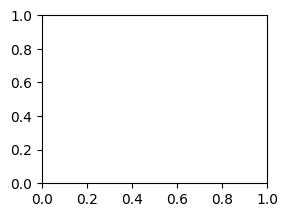

In [10]:
plt.subplot(2,2,1)
plt.errorbar(time,np.mean(scores_color[0],0),np.std(scores_color[0],0),label='color ',color='blue')
plt.errorbar(time,np.mean(scores_color_no_color,0),np.std(scores_color_no_color,0),label='color wo color',color='blue',alpha=0.5)
plt.plot(time,np.ones_like(time)*1/6,'k--')
plt.legend()

plt.subplot(2,2,2)
plt.errorbar(time,np.mean(scores_col2dir[0],0),np.std(scores_col2dir[0],0),label='col2dir',color='orange')
plt.errorbar(time,np.mean(scores_col2dir_no_col2dir,0),np.std(scores_col2dir_no_col2dir,0),label='col2dir wo col2',color='orange',alpha=0.5)
plt.plot(time,np.ones_like(time)*1/6,'k--')
plt.legend()

plt.subplot(2,2,3)
plt.errorbar(time,np.mean(scores_dir[0],0),np.std(scores_dir[0],0),label='dir',color='green')
plt.errorbar(time,np.mean(scores_dir_no_dir,0),np.std(scores_dir_no_dir,0),label='dir wo dir',color='green',alpha=0.5)
plt.plot(time,np.ones_like(time)*1/6,'k--')
plt.legend()

plt.subplot(2,2,4)
plt.errorbar(time,np.mean(scores_choice[0],0),np.std(scores_choice[0],0),label='choice',color='purple')
plt.errorbar(time,np.mean(scores_choice_no_choice,0),np.std(scores_choice_no_choice,0),label='choice wo choice',color='purple',alpha=0.5)
plt.plot(time,np.ones_like(time)*1/2,'k--')
plt.legend()

#plt.ylim(0,1)
sns.despine()
plt.tight_layout()

## run decoders and shuffles

In [11]:

# 1 : color
# -1 : direction

all_scores = []
for var in ["stim_col2dir","stim_dir"]:
    scores,coeff = mante_cross_decode(dataset,var,method="class",cv=10,n_trials=100)


    all_scores.append(scores)
    # dataset_s = dlm.ManteDataset(monkey='A', bin_width=5,smoothing_width=50)

    # scores_shuffle = []
    # coeff_shuffle = []

    # for _ in trange(250):

    #     # shuffle trials
    #     for i in range(len(dataset.units)):
    #         dataset_s.units[i].trials = dataset_s.units[i].trials.sample(frac=1)

    #     scores_s,coeff_s = mante_cross_decode(dataset_s,var,cv=1,method="class",not_verbose=True)
    #     scores_shuffle.append(scores_s[:,0])
    #     #coeff_shuffle.append(coeff_s[:,0])         

    # scores_shuffle= np.array(scores_shuffle)
    # coeff_shuffle= np.array(coeff_shuffle)


    # decoder = {}

    # f=open("../Data/mante/decoding_%s_A_lreg.pickle" % var,"rb")
    # decoder = pickle.load(f)
    # f.close()

    # decoder["scores"] = scores
    # # decoder["coeff"] = coeff

    # f=open("../Data/mante/decoding_%s_A_lreg_no_choice.pickle" % var,"wb")
    # pickle.dump(decoder,f)
    # f.close()


# scores_wo_choice= mante_decode(dataset,"choice",method="class",cv=250)
# dataset_s = dlm.ManteDataset(monkey='A', bin_width=5,smoothing_width=50)

# for unit in range(len(dataset_s.units)):
#    dataset_s.units[unit].trials["choice"] = infer_choices(dataset_s.units[unit])

# scores_choice = mante_decode(dataset_s,"choice",method="class",cv=250)

# scores_shuffle = []
# coeff_shuffle = []

# for _ in trange(250):

#     # shuffle trials
#     for i in range(len(dataset.units)):
#         dataset_s.units[i].trials = dataset_s.units[i].trials.sample(frac=1)

#     scores_s = mante_decode(dataset_s,'choice',cv=1,method="class",not_verbose=True)
#     scores_shuffle.append(scores_s)

# scores_shuffle= np.array(scores_shuffle)

# decoder = {}
# decoder["scores"] = [scores_choice,scores_wo_choice]
# decoder["scores_shuffle"] = scores_shuffle

# f=open("../Data/mante/decoding_choice_A_lreg.pickle","wb")
# pickle.dump(decoder,f)
# f.close()



100%|██████████| 10/10 [13:45<00:00, 82.60s/it]


## plotting

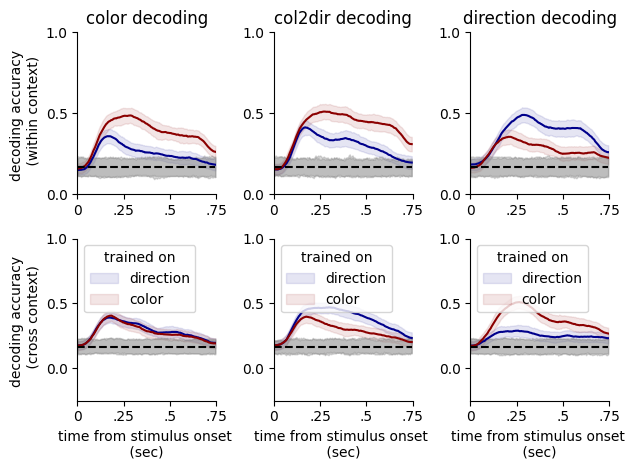

In [12]:

decoders = load_dec('log')

titles = ["color","col2dir","direction"]

fig, axes = plt.subplots(nrows=2, ncols=3)

#decoders["color"]["scores"] = color
#decoders["direction"]["scores"] = all_scores[1]
#decoders["color2dir"]["scores"] = all_scores[0]


for di,decoder in enumerate([decoders["color"] ,decoders["color2dir"],decoders["direction"]]):
 
    shuffle_ci = np.percentile(decoder["scores_shuffle"],[5,95],axis=0)

    axes[0,di].set_title(titles[di]+" decoding")

    # within context decoding
    axes[0,di].plot(time,np.mean(decoder["scores"][0],0),color="darkblue")
    axes[0,di].fill_between(time,np.mean(decoder["scores"][0],0)-np.std(decoder["scores"][0],0),
                    np.mean(decoder["scores"][0],0)+np.std(decoder["scores"][0],0),
                    alpha = 0.1,color="darkblue")

    axes[0,di].plot(time,np.mean(decoder["scores"][3],0),color='darkred')
    axes[0,di].fill_between(time,np.mean(decoder["scores"][3],0)-np.std(decoder["scores"][3],0),
                    np.mean(decoder["scores"][3],0)+np.std(decoder["scores"][3],0),
                    alpha = 0.1,color='darkred')

    [axes[0,di].fill_between(time,shuffle_ci[0,i],shuffle_ci[1,i],color="gray",alpha=0.3) for i in [0,3]]
    
    axes[0,0].set_ylabel("decoding accuracy \n (within context)")
    axes[0,di].plot(time,1/6*np.ones(150),"k--") # 1/6 for accuracy
    axes[1,di].set_ylim(-0.25,1)
    axes[0,di].set_xlim(0,0.75)
    axes[0,di].set_xticks([0,0.25,0.5,0.75],["0",".25",".5",".75"])
    axes[0,di].set_yticks([0,0.5,1])
    
    # cross
    axes[1,di].plot(time,np.mean(decoder["scores"][1],0),color="darkblue")
    axes[1,di].fill_between(time,np.mean(decoder["scores"][1],0)-np.std(decoder["scores"][1],0),
                    np.mean(decoder["scores"][1],0)+np.std(decoder["scores"][1],0),
                    alpha = 0.1,color="darkblue",label="direction")

    axes[1,di].plot(time,np.mean(decoder["scores"][2],0),color="darkred")
    axes[1,di].fill_between(time,np.mean(decoder["scores"][2],0)-np.std(decoder["scores"][2],0),
                    np.mean(decoder["scores"][2],0)+np.std(decoder["scores"][2],0),
                    alpha = 0.1,color="darkred",label="color")

    [axes[1,di].fill_between(time,shuffle_ci[0,i],shuffle_ci[1,i],color="gray",alpha=0.3) for i in [1,2]]

    axes[1,0].set_ylabel("decoding accuracy \n (cross context)")
    axes[1,di].plot(time,1/6*np.ones(150),"k--")
    axes[1,di].set_ylim(-0.25,1)
    axes[1,di].set_xlim(0,0.75)
    axes[1,di].set_xticks([0,0.25,0.5,0.75],["0",".25",".5",".75"])
    axes[1,di].set_yticks([0,0.5,1])

    axes[1,di].set_xlabel("time from stimulus onset \n (sec) ")
    axes[1,di].legend(title="trained on",loc="upper left")

    plt.tight_layout()

    sns.despine()



## calculate cross decoding aligmnet and plot
##### only for regression

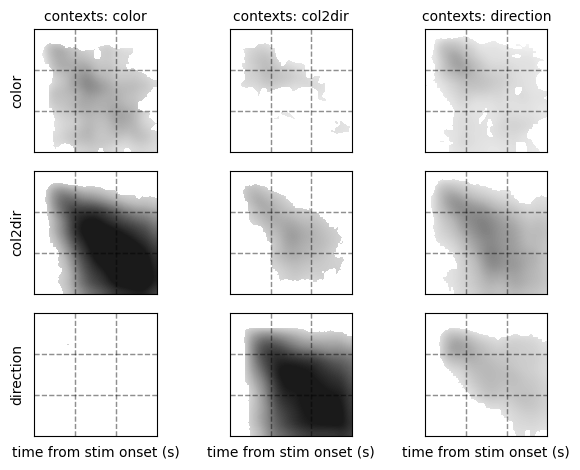

In [ ]:
decoders = load_dec('reg')

fig,axes = plt.subplots(ncols=3,nrows=3)

for di,decoder in enumerate([decoders["color"],decoders["color2dir"], decoders["direction"]]):
   
    m_cross_color,m_cross_dir,m_cross_colordir = cross_aligmnet(decoder)


    for mi,m in enumerate([m_cross_color,m_cross_dir,m_cross_colordir]):
        a = axes[di,mi].imshow(m,extent=[0,750,750,0],vmin=-0.25,vmax=0.25,cmap="RdGy")
        axes[di,mi].set_xticks([])
        axes[di,mi].set_yticks([])

        axes[di,mi].plot([250,250],[0,750],"k--",lw=1,alpha=0.25)
        axes[di,mi].plot([0,750],[250,250],"k--",lw=1,alpha=0.25)
        axes[di,mi].plot([250,250],[0,750],"k--",lw=1,alpha=0.25)
        axes[di,mi].plot([0,750],[250,250],"k--",lw=1,alpha=0.25)

        axes[di,mi].plot([500,500],[0,750],"k--",lw=1,alpha=0.25)
        axes[di,mi].plot([0,750],[500,500],"k--",lw=1,alpha=0.25)
        axes[di,mi].plot([500,500],[0,750],"k--",lw=1,alpha=0.25)
        axes[di,mi].plot([0,750],[500,500],"k--",lw=1,alpha=0.25)

        axes[0,mi].set_title("contexts: " + titles[mi],fontsize=10)
        axes[-1,mi].set_xlabel("time from stim onset (s)")
        axes[di,0].set_ylabel(subtitles[di])
    
    plt.tight_layout()

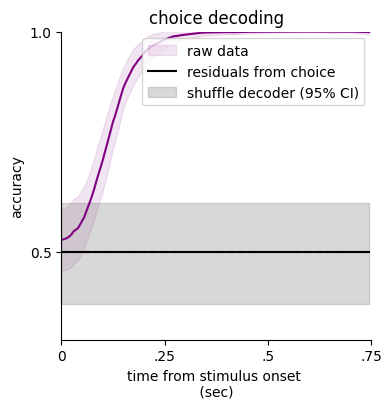

In [ ]:
f=open("../Data/mante/decoding_choice_A_lreg.pickle","rb")
decoders['choice']=pickle.load(f)
f.close()

plt.figure(figsize=(4,4))

decoder = decoders['choice']
plt.plot(time,np.mean(decoder["scores"][0],0),color="purple")
plt.fill_between(time,np.mean(decoder["scores"][0],0)-np.std(decoder["scores"][0],0),
                np.mean(decoder["scores"][0],0)+np.std(decoder["scores"][0],0),
                alpha = 0.1,color="purple",label='raw data')

plt.plot(time,np.mean(decoder["scores"][1],0),color='black',label='residuals from choice')
#plt.fill_between(time,np.mean(decoder["scores"][1],0)-np.std(decoder["scores"][1],0),
#                np.mean(decoder["scores"][1],0)+np.std(decoder["scores"][1],0),
#               alpha = 0.1,color='black',label='residuals from choice')

plt.plot(time,.5*np.ones_like(time),'k--')

shuffle_ci = np.percentile(decoder["scores_shuffle"],[5,95],axis=0)
plt.fill_between(time,shuffle_ci[0],shuffle_ci[1],color="gray",alpha=0.3,label='shuffle decoder (95% CI)')

plt.title("choice decoding")
plt.ylabel("accuracy")
plt.ylim(0.3,1)
plt.xlim(0,0.75)
plt.xticks([0,0.25,0.5,0.75],["0",".25",".5",".75"])
plt.yticks([0.5,1])

plt.xlabel("time from stimulus onset \n (sec) ")
plt.legend(loc='upper right')
sns.despine()